# Working with the ``zea`` data format
In this tutorial notebook we will show how to load a zea data file and how to access the data stored in it. There are three common ways to load a zea data file:

1. Loading data from single file with `zea.File`
2. Loading data from a group of files with `zea.Dataset`
3. Loading data in batches with dataloading utilities with `zea.backend.tensorflow.make_dataloader`

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/data/zea_data_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/data/zea_data_example.ipynb)
&nbsp;
[![Hugging Face dataset](https://img.shields.io/badge/Hugging%20Face-Dataset-yellow?logo=huggingface)](https://huggingface.co/datasets/zeahub/picmus)

‼️ **Important:** This notebook is optimized for **GPU/TPU**. Code execution on a **CPU** may be very slow.

If you are running in Colab, please enable a hardware accelerator via:

**Runtime → Change runtime type → Hardware accelerator → GPU/TPU** 🚀.

In [1]:
%%capture
%pip install zea

In [2]:
config_picmus_iq = "hf://zeahub/configs/config_picmus_iq.yaml"

In [3]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["ZEA_DISABLE_CACHE"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [4]:
import matplotlib.pyplot as plt

import zea
from zea import init_device, load_file
from zea.visualize import set_mpl_style
from zea.backend.tensorflow import make_dataloader

zea: Using backend 'jax'


We will work with the GPU if available, and initialize using `init_device` to pick the best available device. Also, (optionally), we will set the matplotlib style for plotting.

In [5]:
init_device(verbose=False)
set_mpl_style()

## Loading a file with `zea.File`
The zea data format works with HDF5 files. We can open a zea data file using the `h5py` package and have a look at the contents using the `zea.File.summary()` function. You can see that every dataset element contains a corresponding description and unit. Note that we now pass a url to a Hugging Face dataset, but you can also use a local file path to a zea data file. Here we will use an example from the [PICMUS](https://www.creatis.insa-lyon.fr/Challenge/IEEE_IUS_2016/home) dataset, converted to zea format and hosted on the [Hugging Face Hub](https://huggingface.co/datasets/zeahub/picmus).

> *Tip:*
> You can also use the [HDFView](https://www.hdfgroup.org/downloads/hdfview/) tool to view the contents of the zea data file without having to run any code. Or if you use VS Code, you can install the [HDF5 extension](https://marketplace.visualstudio.com/items?itemName=h5web.vscode-h5web) to view the contents of the file.

You can extract data and acquisition parameters (which are stored together with the data in the zea data file) as follows:

In [6]:
file_path = "hf://zeahub/picmus/database/experiments/contrast_speckle/contrast_speckle_expe_dataset_iq/contrast_speckle_expe_dataset_iq.hdf5"

with zea.File(file_path, mode="r") as file:
    file.summary()

    data = file.load_data("raw_data", indices=0)
    scan = file.scan()
    probe = file.probe()

database/experiments/contrast_speckle/co(…):   0%|          | 0.00/64.0M [00:00<?, ?B/s]

contrast_speckle_expe_dataset_iq.hdf5/
    ├── description: PICMUS dataset converted to USBMD format
    ├── probe: verasonics_l11_4v
    ├── data/
    │   ├── description: This group contains the data.
    │   └── raw_data/
    │       ├── /data/raw_data (shape=(1, 75, 832, 128, 2))
    │       │   ├── description: The raw_data of shape (n_frames, n_tx, n_el, n_ax, n_ch).
    │       │   ├── unit: unitless
    └── scan/
        ├── description: This group contains the scan parameters.
        ├── azimuth_angles/
        │   ├── /scan/azimuth_angles (shape=(75))
        │   │   ├── description: The azimuthal angles of the transmit beams in radians of shape (n_tx,).
        │   │   ├── unit: rad
        ├── center_frequency/
        │   ├── /scan/center_frequency (shape=())
        │   │   ├── description: The center frequency in Hz.
        │   │   ├── unit: Hz
        ├── focus_distances/
        │   ├── /scan/focus_distances (shape=(75))
        │   │   ├── description: The transmit 

You can also do this exact thing in one go using `zea.load_file` which will directly return you the data and parameter objects.

In [7]:
data, scan, probe = load_file(file_path, "raw_data", indices=(0, slice(0, 3)))

print("Raw data shape:", data.shape)
print(scan)
print(probe)

zea: DEBUG Skipping invalid parameter 'n_frames'.
Raw data shape: (3, 832, 128, 2)
Scan(
    azimuth_angles=array(shape=(75,)),
    center_frequency=5208000.0,
    focus_distances=array(shape=(75,)),
    initial_times=array(shape=(75,)),
    n_ax=832,
    n_el=128,
    n_tx=75,
    polar_angles=array(shape=(75,)),
    probe_geometry=array(shape=(128, 3)),
    sampling_frequency=5208000.0,
    sound_speed=1540.0,
    t0_delays=array(shape=(75, 128)),
    tx_apodizations=array(shape=(75, 128)),
    selected_transmits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74],
    pixels_per_wavelength=4,
    pfield_kwargs={},
    apply_lens_correction=False,
    grid_type=cartesian,
    dynamic_range=(-60, 0),
    bandwidth_percent=200.0,
    attenuation_coef=

## Loading data with `zea.Dataset`
We can also load and manage a group of files (i.e. a dataset) using the `zea.Dataset` class. Instead of a path to a single file, we can pass a list of file paths or a directory containing multiple zea data files. The `zea.Dataset` class will automatically load the files and allow you to access the data in a similar way as with `zea.File`.

In [8]:
dataset_path = "hf://zeahub/picmus/database/experiments"

dataset = zea.Dataset(dataset_path, key="raw_data")

print(dataset)

for file in dataset:
    print(file)

dataset.close()

database/experiments/contrast_speckle/co(…):   0%|          | 0.00/128M [00:00<?, ?B/s]

database/experiments/resolution_distorsi(…):   0%|          | 0.00/64.0M [00:00<?, ?B/s]

database/experiments/resolution_distorsi(…):   0%|          | 0.00/128M [00:00<?, ?B/s]

zea: Searching /tmp/zea_cache_is7fx3ye/huggingface/datasets/datasets--zeahub--picmus/snapshots/79a57eaa7e4e284cf6bef10df33cc0bdce400190/database/experiments for ['.hdf5', '.h5'] files...
zea: Caching is globally disabled for _find_h5_file_shapes.


zea: Dataset validated. Check /tmp/zea_cache_is7fx3ye/huggingface/datasets/datasets--zeahub--picmus/snapshots/79a57eaa7e4e284cf6bef10df33cc0bdce400190/database/experiments/validated.flag for details.
Dataset with 4 files (key='raw_data')
zea HDF5 File: 'contrast_speckle_expe_dataset_rf.hdf5' (mode=r)
zea HDF5 File: 'contrast_speckle_expe_dataset_iq.hdf5' (mode=r)
zea HDF5 File: 'resolution_distorsion_expe_dataset_rf.hdf5' (mode=r)
zea HDF5 File: 'resolution_distorsion_expe_dataset_iq.hdf5' (mode=r)
zea: Closed all cached file handles.


## Loading data with `make_dataloader`

In machine and deep learning workflows, we often want more features like batching, shuffling, and parallel data loading. The `zea.backend.tensorflow.make_dataloader` function provides a convenient way to create a TensorFlow data loader from a zea  dataset. This does require a working TensorFlow installation, but does work in combination with any other backend as well. This dataloader is particularly useful for training models. It is important that there is some consistency in the dataset, which is not the case for [PICMUS](https://www.creatis.insa-lyon.fr/Challenge/IEEE_IUS_2016/home). Therefore in this example we will use a small part of the [CAMUS](https://www.creatis.insa-lyon.fr/Challenge/camus/) dataset.

val/patient0401/patient0401_2CH_half_seq(…):   0%|          | 0.00/44.5M [00:00<?, ?B/s]

val/patient0401/patient0401_4CH_half_seq(…):   0%|          | 0.00/44.3M [00:00<?, ?B/s]

zea: Searching /tmp/zea_cache_is7fx3ye/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val for ['.hdf5', '.h5'] files...
zea: Caching is globally disabled for _find_h5_file_shapes.


zea: Dataset validated. Check /tmp/zea_cache_is7fx3ye/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag for details.
zea: WARNING H5Generator: Not all files have the same shape. This can lead to issues when resizing images later....
zea: H5Generator: Shuffled data.


zea: H5Generator: Shuffled data.
Batch shape: (4, 256, 256, 1)


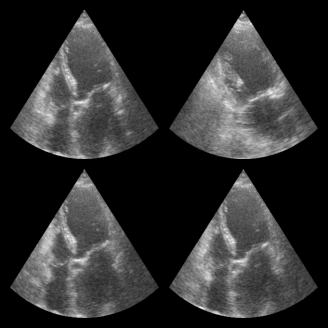

In [9]:
dataset_path = "hf://zeahub/camus-sample/val"
dataloader = make_dataloader(
    dataset_path,
    key="data/image_sc",
    batch_size=4,
    shuffle=True,
    clip_image_range=[-60, 0],
    image_range=[-60, 0],
    normalization_range=[0, 1],
    image_size=(256, 256),
    resize_type="resize",  # or "center_crop or "random_crop"
    seed=4,
)

for batch in dataloader:
    print("Batch shape:", batch.shape)
    break  # Just show the first batch

fig, _ = zea.visualize.plot_image_grid(batch)

## Processing an example
We will now use one of the zea data files to demonstrate how to process it. A full example can be found in the [zea_pipeline_example](../pipeline/zea_pipeline_example.ipynb) notebook. Here we will just show a simple example for completeness. We will start by loading a config file, that contains all the required information to initiate a processing pipeline.

In [10]:
config = zea.Config.from_path(config_picmus_iq)

config_picmus_iq.yaml: 0.00B [00:00, ?B/s]

Now we can load the zea data file, extract data and parameters, and then process the data using the pipeline defined by the config file.

In [11]:
with zea.File(config.data.dataset_folder + "/" + config.data.file_path, mode="r") as file:
    # we use config here to overwrite some of the scan parameters
    scan = file.scan(**config.scan)
    data = file.load_data(config.data.dtype)

pipeline = zea.Pipeline.from_config(config.pipeline)
parameters = pipeline.prepare_parameters(probe=probe, scan=scan)

images = pipeline(data=data, **parameters)["data"]

database/simulation/contrast_speckle/con(…):   0%|          | 0.00/36.4M [00:00<?, ?B/s]

zea: DEBUG Skipping invalid parameter 'n_frames'.


Finally we can plot the result.

Text(0, 0.5, 'Z (mm)')

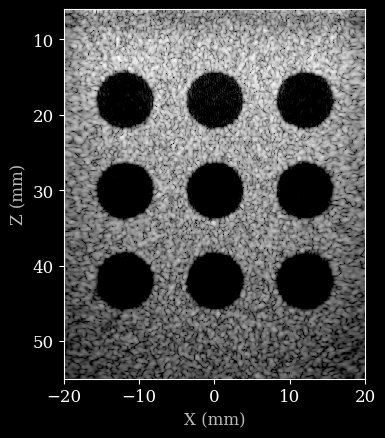

In [12]:
image = zea.display.to_8bit(images[0], dynamic_range=(-50, 0))
plt.figure()
# Convert xlims and zlims from meters to millimeters for display
xlims_mm = [v * 1e3 for v in scan.xlims]
zlims_mm = [v * 1e3 for v in scan.zlims]
plt.imshow(image, cmap="gray", extent=[xlims_mm[0], xlims_mm[1], zlims_mm[1], zlims_mm[0]])
plt.xlabel("X (mm)")
plt.ylabel("Z (mm)")